# SPECIES PREDICTION MODEL PIPELINE (Deep Learning)

## Imports

In [35]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    LabelEncoder
)

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [36]:
df = pd.read_csv("../imputation_model/raw_data/field_genetics_species.csv")
df.head()

,date,watershed,river,site,method,local,water_temp_start,fork_length_mm,annoted_species,confirmed_species,tag_id_long
0,2021-06-02,puntledge,puntledge,above tsolum,beach seine,in-river,13.4,85.0,ck,coho,989.001038864826
1,2021-06-02,puntledge,puntledge,above tsolum,beach seine,in-river,13.4,85.0,ck,chinook,989.001038864862
2,2021-06-02,puntledge,puntledge,above tsolum,beach seine,in-river,13.4,85.0,ck,chinook,989.001038864891
3,2021-06-02,puntledge,puntledge,above tsolum,beach seine,in-river,13.4,85.0,ck,chinook,989.001038864827
4,2021-06-02,puntledge,puntledge,above tsolum,beach seine,in-river,13.4,85.0,ck,chinook,989.001038864865


In [37]:
df.annoted_species.unique()

array(['ck', 'co', 'rbt', nan], dtype=object)

In [38]:
df.confirmed_species.unique()

array(['coho', 'chinook', 'steelhead'], dtype=object)

In [39]:
df_clean = df.drop(['tag_id_long', 'water_temp_start'], axis = 1)
df_clean = df_clean.dropna()

In [40]:
df_clean.isnull().sum()

date                 0
watershed            0
river                0
site                 0
method               0
local                0
fork_length_mm       0
annoted_species      0
confirmed_species    0
dtype: int64

In [41]:
df_sampled = df_clean[df_clean['confirmed_species'] == 'chinook'].sample(n=300, random_state=42)
others_combined = df_clean[df_clean['confirmed_species'].isin(["coho", "steelhead"])]
df_sampled = pd.concat([df_sampled, others_combined], axis=0)
df_sampled = df_sampled.reset_index(drop=True)

## Pipeline

In [42]:
X = df_sampled.drop(['confirmed_species', 'annoted_species'], axis = 1)
y = df_sampled['confirmed_species']

In [43]:
X["year"] = pd.DatetimeIndex(X['date']).year
X['day_of_year'] = pd.to_datetime(X['date']).dt.dayofyear
X.head()

,date,watershed,river,site,method,local,fork_length_mm,year,day_of_year
0,2022-06-17,puntledge,puntledge,little mexico,beach seine,marine,93.0,2022,168
1,2022-06-06,nanaimo,nanaimo,jack point,beach seine,marine,69.0,2022,157
2,2021-06-07,nanaimo,nanaimo,jack point,beach seine,marine,79.0,2021,158
3,2022-06-01,nanaimo,nanaimo,jack point,beach seine,marine,62.0,2022,152
4,2021-06-11,nanaimo,nanaimo,cedar bridge,beach seine,in-river,89.0,2021,162


In [44]:
numeric_feats = ["fork_length_mm", "day_of_year"]  # apply scaling
categorical_feats = ["watershed", "river", "site", "method", "local", "year"]  # apply one-hot encoding
# passthrough_feats = [""]  # do not apply any transformation
drop_feats = [ "date" ]  
# levels = ["", ""]

In [45]:
ct = make_column_transformer (    
    (StandardScaler(), numeric_feats),  
    #("passthrough", passthrough_feats),     
    (OneHotEncoder(), categorical_feats),  
    ("drop", drop_feats), 
    #OrdinalEncoder(categories=[levels], dtype=int)
)

In [46]:
transformed = ct.fit_transform(X)

In [47]:
column_names = (
    numeric_feats
    # + passthrough_feats    
    + ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)
column_names

['fork_length_mm',
 'day_of_year',
 'watershed_nanaimo',
 'watershed_puntledge',
 'river_nanaimo',
 'river_puntledge',
 'site_above tsolum',
 'site_cedar bridge',
 'site_condensory bridge',
 'site_jack point',
 'site_little mexico',
 'site_living forest',
 'site_newcastle',
 'site_snuneymuxw beach',
 'site_tsolum confluence',
 'method_beach seine',
 'local_in-river',
 'local_marine',
 'year_2021',
 'year_2022',
 'year_2023']

In [48]:
X_transformed = pd.DataFrame(transformed, columns=column_names)
X_transformed.head()

,fork_length_mm,day_of_year,watershed_nanaimo,watershed_puntledge,river_nanaimo,river_puntledge,site_above tsolum,site_cedar bridge,site_condensory bridge,site_jack point,...,site_living forest,site_newcastle,site_snuneymuxw beach,site_tsolum confluence,method_beach seine,local_in-river,local_marine,year_2021,year_2022,year_2023
0,-0.280810,0.733807,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-1.354080,-0.898374,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.906884,-0.749994,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,-1.667117,-1.640275,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,-0.459688,-0.156474,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


### Dummy model

In [49]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_transformed, y)
dummy_clf.score(X_transformed, y)

0.49586776859504134

### Deep learning - tensorflow

In [50]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_label = tf.keras.utils.to_categorical(y_enc)

In [51]:
le.classes_ 

array(['chinook', 'coho', 'steelhead'], dtype=object)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_label, test_size=0.2, random_state=42)

In [53]:
num_features = X_transformed.shape[1]
dl_model = tf.keras.Sequential([
    layers.Input(shape=(num_features,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  #change based on number of labels
])

In [54]:
dl_model.compile(optimizer=Adam(learning_rate=0.0001),        
    loss='categorical_crossentropy',  
    metrics=['accuracy']) 

dl_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               2816      
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 11,267
Trainable params: 11,267
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = dl_model.fit(X_train, y_train, 
                    epochs = 20, 
                    batch_size = 32, 
                    validation_split=0.2)

Epoch 1/20
13/13 [==============================] - 1s 23ms/step - loss: 1.1367 - accuracy: 0.2248 - val_loss: 1.0887 - val_accuracy: 0.3608
Epoch 2/20
13/13 [==============================] - 0s 7ms/step - loss: 1.0594 - accuracy: 0.3540 - val_loss: 1.0151 - val_accuracy: 0.5052
Epoch 3/20
13/13 [==============================] - 0s 6ms/step - loss: 0.9890 - accuracy: 0.5581 - val_loss: 0.9496 - val_accuracy: 0.5979
Epoch 4/20
13/13 [==============================] - 0s 5ms/step - loss: 0.9262 - accuracy: 0.6977 - val_loss: 0.8906 - val_accuracy: 0.7320
Epoch 5/20
13/13 [==============================] - 0s 4ms/step - loss: 0.8696 - accuracy: 0.8140 - val_loss: 0.8379 - val_accuracy: 0.8144
Epoch 6/20
13/13 [==============================] - 0s 4ms/step - loss: 0.8175 - accuracy: 0.8837 - val_loss: 0.7876 - val_accuracy: 0.9175
Epoch 7/20
13/13 [==============================] - 0s 4ms/step - loss: 0.7679 - accuracy: 0.9147 - val_loss: 0.7401 - val_accuracy: 0.9072
Epoch 8/20
13/13 [=

In [56]:
def plot_acc(history):
    fig = plt.figure(0, (12, 4))

    ax = plt.subplot(1, 2, 1)
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
    plt.title('Accuracy')
    plt.tight_layout()

    ax = plt.subplot(1, 2, 2)
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
    plt.title('Loss')
    plt.tight_layout()

    plt.show()

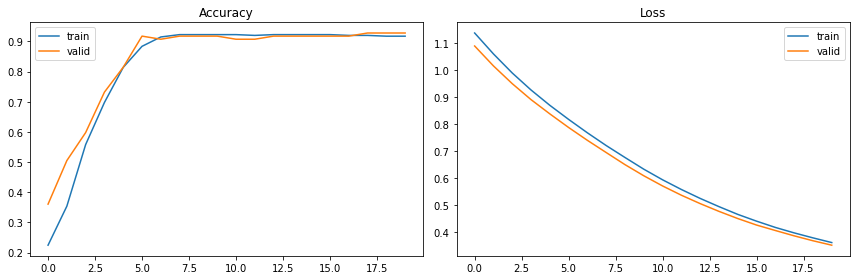

In [57]:
plot_acc(history)

### Saving the model

In [61]:
dl_model.save('model/imputation_model.h5')

### Validation

In [59]:
y_pred = dl_model.predict(X_test)

4/4 [==============================] - 0s 3ms/step


In [60]:
prediction = pd.DataFrame(y_pred, columns=le.classes_)
prediction.head()

,chinook,coho,steelhead
0,0.174190,0.784157,0.041653
1,0.727227,0.234611,0.038162
2,0.659094,0.272211,0.068695
3,0.816837,0.141899,0.041265
4,0.682833,0.284131,0.033036


1. Make a table that shows tag id, prediction, confidence, genetic_result, annotated result
2. Then take accuracy